In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2024-07-24 04:24:36.871729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 04:24:36.871852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 04:24:37.057809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

data = pd.read_csv('../input/breakhis/Folds.csv')

In [4]:

img_dir = '../input/breakhis/BreaKHis_v1/'

In [5]:

data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: 1 if x == 'malignant' else 0)
data['filename'] = data.path.apply(lambda x: os.path.join(img_dir, x))

In [6]:

X = data['filename']
y = data['label_int']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:

data['label_int'] = data['label_int'].astype(str)

In [8]:

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:

base_model.trainable = False

In [10]:

model = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [11]:

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       983,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,306,049 (73.65 MB)

 Trainable params: 984,065 (3.75 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [13]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print(data.head())

   fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

    label label_int                                           filename  
0  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  
1  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  
2  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  
3  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  
4  benign         0  ../input/breakhis/BreaKHis_v1/BreaKHis_v1/hist...  


In [14]:
# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data.loc[data.index.isin(X_train.index)],
    x_col='filename',
    y_col='label_int',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=data.loc[data.index.isin(X_val.index)],
    x_col='filename',
    y_col='label_int',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data.loc[data.index.isin(X_test.index)],
    x_col='filename',
    y_col='label_int',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 31636 validated image filenames belonging to 2 classes.
Found 3954 validated image filenames belonging to 2 classes.
Found 3955 validated image filenames belonging to 2 classes.


In [15]:



print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Training samples: 31636
Validation samples: 3954
Test samples: 3955


In [16]:

if train_generator.samples == 0:
    raise ValueError("No training images found. Check the training directory.")
if val_generator.samples == 0:
    raise ValueError("No validation images found. Check the validation directory.")
if test_generator.samples == 0:
    raise ValueError("No test images found. Check the test directory.")

In [17]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

In [18]:
# Train
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721795270.895761     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721795271.009791     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


899/988 ━━━━━━━━━━━━━━━━━━━━ 1:12 817ms/step - accuracy: 0.7713 - loss: 0.4817

W0000 00:00:1721796004.837987     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.7760 - loss: 0.4747

W0000 00:00:1721796081.083551     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 928s 871ms/step - accuracy: 0.7760 - loss: 0.4746 - val_accuracy: 0.8928 - val_loss: 0.2909
Epoch 2/10
  1/988 ━━━━━━━━━━━━━━━━━━━━ 1:46 108ms/step - accuracy: 0.8438 - loss: 0.3470

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


988/988 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8438 - loss: 0.3470 - val_accuracy: 0.7778 - val_loss: 0.4471
Epoch 3/10


W0000 00:00:1721796157.973852     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 739s 743ms/step - accuracy: 0.8746 - loss: 0.3176 - val_accuracy: 0.9045 - val_loss: 0.2495
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 108us/step - accuracy: 0.8438 - loss: 0.3379 - val_accuracy: 0.9444 - val_loss: 0.2601
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 737s 740ms/step - accuracy: 0.8894 - loss: 0.2779 - val_accuracy: 0.9149 - val_loss: 0.2339
Epoch 6/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 138us/step - accuracy: 0.9062 - loss: 0.2293 - val_accuracy: 0.8333 - val_loss: 0.2573
Epoch 7/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 733s 737ms/step - accuracy: 0.9040 - loss: 0.2493 - val_accuracy: 0.9223 - val_loss: 0.2033
Epoch 8/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - accuracy: 0.8750 - loss: 0.3292 - val_accuracy: 0.9444 - val_loss: 0.1486
Epoch 9/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 739s 743ms/step - accuracy: 0.9123 - loss: 0.2252 - val_accuracy: 0.9294 - val_loss: 0.1871
Epoch 10/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.8438 - loss: 0.2644 - va

In [19]:

for layer in base_model.layers[-10:]:
    layer.trainable = True

In [20]:

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/5
  1/988 ━━━━━━━━━━━━━━━━━━━━ 12:41:36 46s/step - accuracy: 0.8438 - loss: 0.3296

W0000 00:00:1721799164.913219     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


609/988 ━━━━━━━━━━━━━━━━━━━━ 4:36 730ms/step - accuracy: 0.8877 - loss: 0.2808

W0000 00:00:1721799608.521861     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.8917 - loss: 0.2709

W0000 00:00:1721799886.464278     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 818s 782ms/step - accuracy: 0.8917 - loss: 0.2708 - val_accuracy: 0.9243 - val_loss: 0.1963
Epoch 2/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8750 - loss: 0.2871 - val_accuracy: 0.8889 - val_loss: 0.1637
Epoch 3/5


W0000 00:00:1721799945.975284     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


988/988 ━━━━━━━━━━━━━━━━━━━━ 739s 743ms/step - accuracy: 0.9157 - loss: 0.2117 - val_accuracy: 0.9334 - val_loss: 0.1679
Epoch 4/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 0s 107us/step - accuracy: 0.9375 - loss: 0.2614 - val_accuracy: 0.8889 - val_loss: 0.2687
Epoch 5/5
988/988 ━━━━━━━━━━━━━━━━━━━━ 736s 740ms/step - accuracy: 0.9169 - loss: 0.2072 - val_accuracy: 0.9400 - val_loss: 0.1504


In [22]:
# Evaluate 
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

123/123 ━━━━━━━━━━━━━━━━━━━━ 51s 409ms/step - accuracy: 0.9406 - loss: 0.1547
Test Loss: 0.1562
Test Accuracy: 0.9390


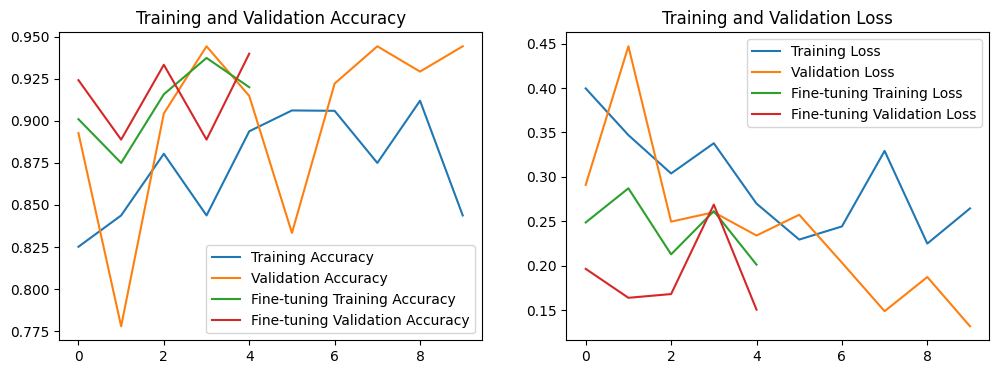

In [23]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuning Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuning Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuning Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()